In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import spacy
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Bidirectional,LSTM,Dense,Input,Embedding,Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import gensim
from keras.initializers import Constant
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle

In [2]:
df=pd.read_csv('languages.csv')
df.head()

,text,language
0,ich denke es handelt sich hier um ein missvers...,german
1,ich habe tom gerade erst verlassen,german
2,tom versuchte mary nur zu ärgern,german
3,tom hat mir die hand geküsst,german
4,ich wusste dass dir das gefiele,german


In [3]:
df.shape

(763684, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763684 entries, 0 to 763683
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      763684 non-null  object
 1   language  763684 non-null  object
dtypes: object(2)
memory usage: 11.7+ MB


In [5]:
df.isnull().sum()

text        0
language    0
dtype: int64

In [6]:
df['language'].value_counts()

language
english    275687
german     199618
french     169693
spanish    118686
Name: count, dtype: int64

In [7]:
df_english=df[df['language']=='english'].sample(40000)
df_german=df[df['language']=='german'].sample(40000)
df_french=df[df['language']=='french'].sample(40000)
df_spanish=df[df['language']=='spanish'].sample(40000)

In [8]:
df_balanced=pd.concat([df_english,df_german,df_french,df_spanish])
df_balanced.head()

,text,language
508958,i am always at home on sundays,english
730623,we have a freezer in the basement,english
621516,tom doesnt have any friends to talk to,english
559669,i needed that job,english
566201,i deactivated my twitter account yesterday,english


In [9]:
df_balanced.shape

(160000, 2)

In [10]:
sw_e=stopwords.words('english')
sw_g=stopwords.words('german')
sw_f=stopwords.words('french')
sw_s=stopwords.words('spanish')

In [11]:
lemmatizer=WordNetLemmatizer()

In [12]:
def text_preprocessing(text):
    text=text.lower()
    text=re.sub('[^a-z]',' ',text)
    text=re.sub('\s+[a-z]\s+',' ',text)
    text=re.sub('\s+',' ',text)
    words=[word for word in text.split() if word not in sw_e]
    words=[word for word in words if word not in sw_g]
    words=[word for word in words if word not in sw_f]
    words=[word for word in words if word not in sw_s]
    words=[lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [13]:
df_balanced['cl_text']=df_balanced['text'].apply(text_preprocessing)

In [14]:
df_balanced.head()

,text,language,cl_text
508958,i am always at home on sundays,english,always home sunday
730623,we have a freezer in the basement,english,freezer basement
621516,tom doesnt have any friends to talk to,english,tom doesnt friend talk
559669,i needed that job,english,needed job
566201,i deactivated my twitter account yesterday,english,deactivated twitter account yesterday


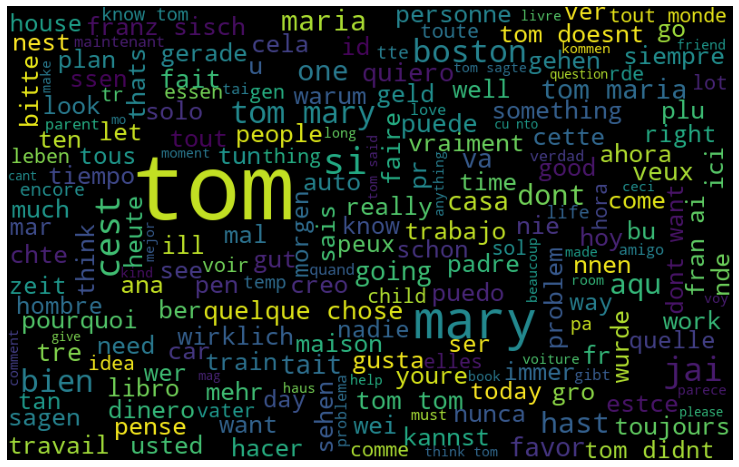

In [15]:
plt.figure(figsize=(13,9))
all_text=' '.join([sentence for sentence in df_balanced['cl_text']])
wordcloud_all=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(all_text)
plt.imshow(wordcloud_all)
plt.axis('off')
plt.show()

In [16]:
def vis(stm):
    plt.figure(figsize=(13,9))
    sen=' '.join([sentence for sentence in df_balanced['cl_text'][df_balanced['language']==stm]])
    wordcloud_sen=WordCloud(width=800,height=500,random_state=101,max_font_size=100).generate(sen)
    plt.imshow(wordcloud_sen)
    plt.axis('off')
    plt.show()

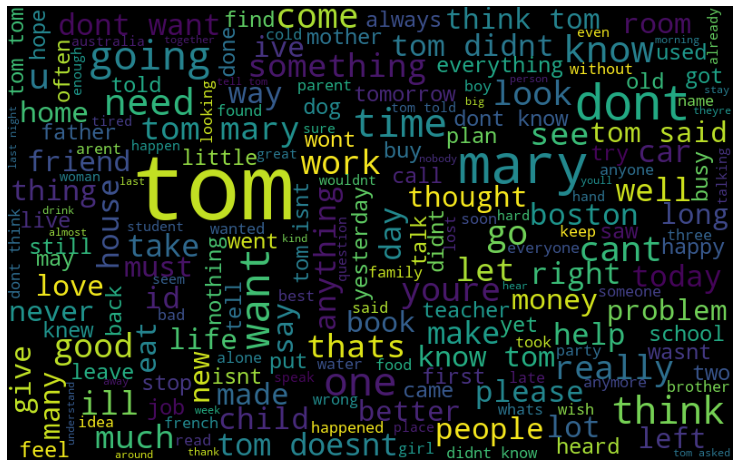

In [17]:
vis('english')

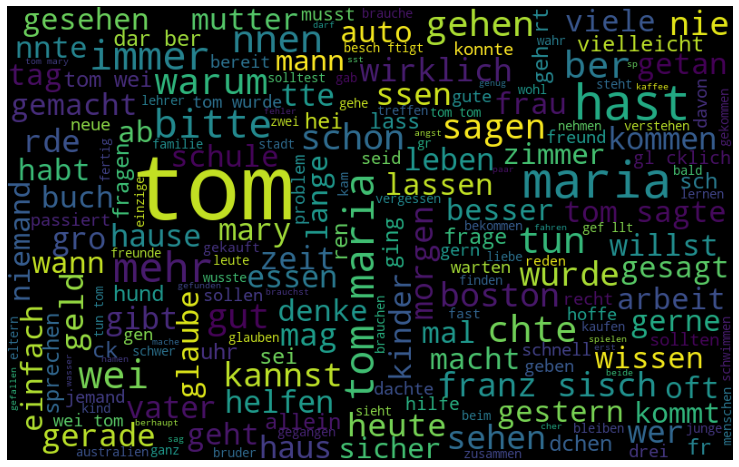

In [18]:
vis('german')

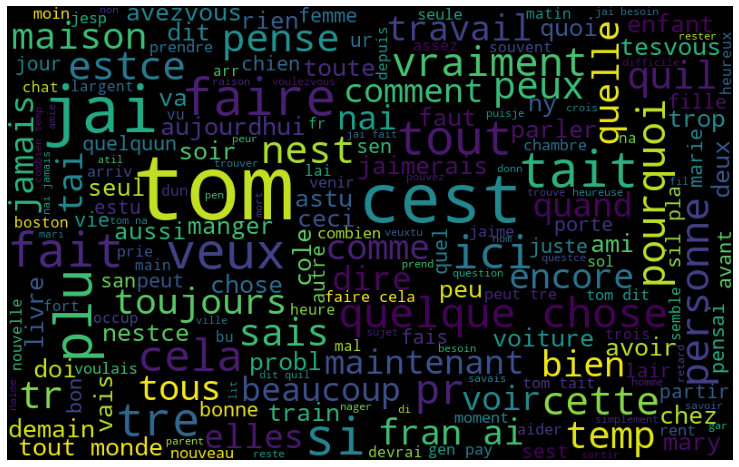

In [19]:
vis('french')

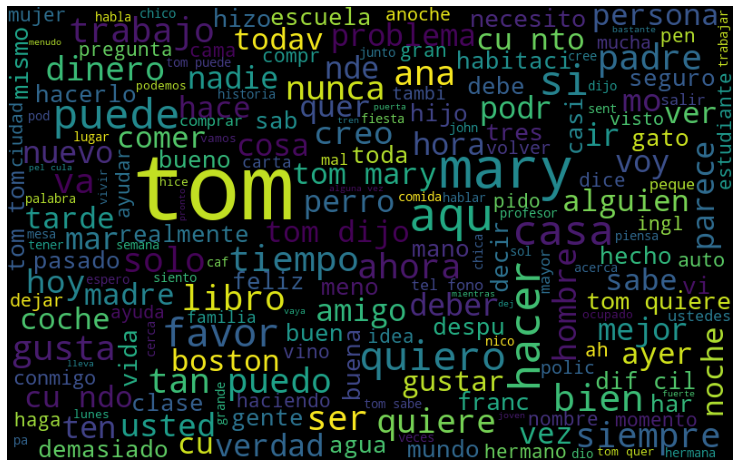

In [20]:
vis('spanish')

In [21]:
nlp=spacy.load('en_core_web_lg')

In [22]:
def get_vector(text):
    return nlp(text).vector

In [23]:
df_balanced['vector']=df_balanced['cl_text'].apply(get_vector)

In [24]:
df_balanced.head()

,text,language,cl_text,vector
508958,i am always at home on sundays,english,always home sunday,"[0.20626199, 0.7434666, -2.8685665, 0.28696334..."
730623,we have a freezer in the basement,english,freezer basement,"[1.2267001, -1.73559, -2.1542, 3.62035, 1.8473..."
621516,tom doesnt have any friends to talk to,english,tom doesnt friend talk,"[1.177782, 5.054936, -4.92546, -1.3420404, -3...."
559669,i needed that job,english,needed job,"[2.49945, 3.05415, -5.5205503, -1.76098, 1.128..."
566201,i deactivated my twitter account yesterday,english,deactivated twitter account yesterday,"[-0.0055350214, -1.30815, 0.9190325, 0.792875,..."


In [25]:
le=LabelEncoder()
y=le.fit_transform(df_balanced['language'])

In [26]:
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
X=df_balanced['vector']

In [28]:
X[:10]

508958    [0.20626199, 0.7434666, -2.8685665, 0.28696334...
730623    [1.2267001, -1.73559, -2.1542, 3.62035, 1.8473...
621516    [1.177782, 5.054936, -4.92546, -1.3420404, -3....
559669    [2.49945, 3.05415, -5.5205503, -1.76098, 1.128...
566201    [-0.0055350214, -1.30815, 0.9190325, 0.792875,...
705012    [-0.19082499, 1.6485, -2.8094249, -0.46616995,...
614225    [-0.24186699, 1.7149667, -2.8408267, 0.1943166...
491048    [0.33125004, 1.9501182, -4.4143033, 0.26599833...
671084    [1.72323, 3.7564335, -5.3787827, 0.4468, -2.51...
700460    [0.7967651, -0.256465, -1.1202685, 0.6945367, ...
Name: vector, dtype: object

In [29]:
X_2D=np.stack(X)

In [30]:
X_2D

array([[ 0.20626199,  0.7434666 , -2.8685665 , ...,  0.30053332,
        -3.3462067 ,  0.20338666],
       [ 1.2267001 , -1.73559   , -2.1542    , ..., -1.71575   ,
         0.461225  ,  0.482656  ],
       [ 1.177782  ,  5.054936  , -4.92546   , ...,  0.71575415,
        -2.70982   ,  1.8903182 ],
       ...,
       [-0.39855498,  2.17905   , -0.54977494, ..., -0.5231501 ,
        -1.43927   , -0.21466376],
       [-1.280115  ,  0.181655  , -0.1637925 , ...,  1.2375575 ,
        -1.179576  ,  0.55619997],
       [ 0.59387   ,  0.36043397, -0.37111998, ..., -0.91294   ,
        -0.5138    , -0.7034504 ]], dtype=float32)

In [31]:
pipeline=Pipeline([
    ('scaler',MinMaxScaler()),
    ('nb',MultinomialNB())
])

In [32]:
X_train,X_test,y_train,y_test=train_test_split(X_2D,y,test_size=0.2,random_state=101,stratify=y,shuffle=True)

In [33]:
X_train.shape

(128000, 300)

In [34]:
X_test.shape

(32000, 300)

In [35]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('nb', MultinomialNB())])

In [36]:
y_pred=pipeline.predict(X_test)

In [37]:
y_pred[:10]

array([0, 2, 3, 0, 2, 2, 1, 0, 2, 2])

In [38]:
y_test[:10]

array([0, 2, 3, 0, 2, 2, 1, 3, 3, 2])

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      8000
           1       0.89      0.77      0.82      8000
           2       0.65      0.95      0.77      8000
           3       0.92      0.69      0.79      8000

    accuracy                           0.82     32000
   macro avg       0.85      0.82      0.82     32000
weighted avg       0.85      0.82      0.82     32000



In [40]:
tokenizer=Tokenizer()

In [41]:
tokenizer.fit_on_texts(df_balanced['cl_text'])
seq=tokenizer.texts_to_sequences(df_balanced['cl_text'])

In [42]:
seq[:10]

[[205, 162, 2159],
 [12615, 12616],
 [1, 61, 226, 269],
 [1389, 279],
 [25841, 11035, 3875, 408],
 [532, 1199, 12, 688],
 [657, 9776, 1737],
 [3369, 51, 154, 14939, 24, 172],
 [62, 14940],
 [1, 6067, 156, 1344, 404, 408]]

In [43]:
maxlen=max([len(i) for i in seq])

In [44]:
vocab_size=len(tokenizer.word_index)+1

In [45]:
maxlen

42

In [46]:
vocab_size

47786

In [47]:
pad_seq=pad_sequences(seq,maxlen=maxlen,padding='post')

In [48]:
pad_seq

array([[  205,   162,  2159, ...,     0,     0,     0],
       [12615, 12616,     0, ...,     0,     0,     0],
       [    1,    61,   226, ...,     0,     0,     0],
       ...,
       [ 4920,  5072,    80, ...,     0,     0,     0],
       [ 1861,   326,   173, ...,     0,     0,     0],
       [  584,  4298,   856, ...,     0,     0,     0]])

In [49]:
wv_model=gensim.models.Word2Vec(window=10,
                               min_count=2,
                               workers=4)

In [50]:
wv_seq=df_balanced['cl_text'].apply(gensim.utils.simple_preprocess)

In [51]:
wv_seq

508958                        [always, home, sunday]
730623                           [freezer, basement]
621516                   [tom, doesnt, friend, talk]
559669                                 [needed, job]
566201    [deactivated, twitter, account, yesterday]
                             ...                    
396144                             [dirige, palabra]
369339                               [devolvi, beso]
484514                     [quise, sonar, tan, duro]
464386                 [pensaba, sab, hablar, franc]
458763                          [dej, revista, mesa]
Name: cl_text, Length: 160000, dtype: object

In [52]:
wv_model.build_vocab(wv_seq)

In [53]:
len(wv_seq)

160000

In [54]:
wv_model.train(wv_seq,total_examples=160000,epochs=30)

(14456914, 16015200)

In [55]:
wv_model.wv.most_similar('good')

[('easy', 0.732664167881012),
 ('tough', 0.7281565070152283),
 ('scary', 0.7275903224945068),
 ('improving', 0.723555862903595),
 ('apply', 0.7161227464675903),
 ('great', 0.7119881510734558),
 ('nervous', 0.7115199565887451),
 ('gaining', 0.7069587707519531),
 ('boring', 0.7066863179206848),
 ('anxious', 0.7044489979743958)]

In [56]:
wv_model.wv.similarity(w1='phone',w2='ipad')

0.2483738

In [57]:
wv_model.wv['good']

array([ 0.7207532 ,  0.05127958,  2.0920243 , -1.192806  ,  0.4060182 ,
       -2.271061  ,  0.08633047,  0.81730455, -1.8735491 , -0.8648106 ,
        0.12818703, -0.49613217,  0.5439173 ,  0.13361463,  2.3640232 ,
        0.8925127 , -0.7354346 ,  0.56634414,  1.0451087 , -1.1682724 ,
        0.9122196 , -1.211681  ,  0.05585311, -2.1319618 , -0.58326346,
       -0.32920736, -0.7231069 , -1.3817408 ,  0.576663  , -0.5300874 ,
       -1.1075052 , -0.9318213 ,  1.7824844 ,  1.0955421 , -1.3249046 ,
       -0.5300221 , -0.70736605,  1.3856989 , -1.8446105 , -0.5790288 ,
       -0.12457331,  0.9638616 ,  2.4611833 ,  0.52856123,  0.6437088 ,
       -0.46978003,  1.2573721 , -1.703124  , -0.93120664,  1.0643693 ,
       -0.42814425,  0.01279822, -1.2754526 , -1.7565101 ,  0.36350313,
        0.36944595, -1.3824247 ,  0.8936113 ,  1.4686297 , -0.8278818 ,
       -1.2885882 ,  0.1759913 ,  2.038648  ,  0.8791509 ,  0.09452885,
       -0.70834655, -0.6208879 ,  1.6447676 ,  0.34564412,  1.48

In [58]:
len(wv_model.wv['good'])

100

In [59]:
def embedding(model):
    embedding_matrix=np.zeros((vocab_size,100))
    for word,index in tokenizer.word_index.items():
        embedding_matrix[index]=wv_model.wv[word]
        return embedding_matrix

In [60]:
embedding_vectors=embedding(wv_model)

In [61]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.59909344, -0.00774996, -0.33209276, ...,  0.06157484,
         0.05365149, -0.1905182 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [62]:
model2=Sequential()

In [63]:
model2.add(Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_vectors),trainable=False))
model2.add(Conv1D(32,3,padding='same',activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.2))
model2.add(Dense(4,activation='softmax'))

In [64]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [66]:
early_stopping=EarlyStopping(monitor='val_loss',patience=2)

In [67]:
X_f,y_f=shuffle(pad_seq,y)

In [69]:
history=model2.fit(X_f,y_f,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 328s 73ms/step - accuracy: 0.9945 - loss: 0.0127 - val_accuracy: 0.9786 - val_loss: 0.0632
Epoch 2/100
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 321s 71ms/step - accuracy: 0.9943 - loss: 0.0124 - val_accuracy: 0.9787 - val_loss: 0.0640
